# Figure 3

In [1]:
import sys
sys.path.insert(1, '../code/scripts')

In [2]:
## Basics
import os.path
from os import path
from scipy import stats
import numpy as np
import pandas as pd
import seaborn as sns
import mdtraj as md
import parseaf as pa

## Logistic regression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

## Plotting
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams.update({'font.size': 14})
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = "Arial"

## Colors
cscheme = {'pos':'#0177BB', 'neg':'#CB3627', 'dis':'#828282', 'helix':'#009988', 'sheet':'#EE7733', 'cr':'#AA4499'}

In [3]:
import warnings
warnings.filterwarnings('ignore')

## Functions

In [4]:
def get_aa_freq(seq, aa):
    cnt = 0
    for i in seq:
        if i == aa:
            cnt += 1
    aa_freq = cnt / len(seq)
    return aa_freq

In [5]:
def append_percent_aa(row, aa):
    seq = row['region_seq']
    if len(seq) == 0:
        print(row['uni_id'])
    return get_aa_freq(seq, aa)

## Data

In [6]:
allregions = pd.read_csv('../data/af_regions/sc_af_regions_all.csv')

## 3A: Logistic regression model coefficients

In [7]:
states = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
          'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

In [8]:
for aa in states:
    allregions['freq_'+aa] = allregions.apply(lambda row: append_percent_aa(row, aa), axis=1)

In [9]:
featurecol = []
for aa in states:
    featurecol.append('freq_'+aa)
X = allregions[featurecol]
y = allregions['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
cnf_all = metrics.confusion_matrix(y_test, y_pred)
metrics.accuracy_score(y_test, y_pred)

0.9246841593780369

In [10]:
df_lr = pd.DataFrame(columns=['aa','coef'])
for i in range(20):
    df_lr = df_lr.append({'aa': states[i], 'coef': logreg.coef_[0][i]}, ignore_index=True)
df_lr = df_lr.sort_values(by='coef', ascending=False, key=abs)

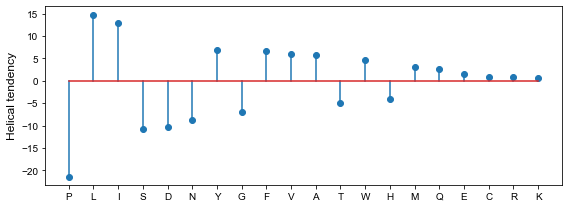

In [11]:
plt.figure(figsize=(8,3))
plt.stem(df_lr['aa'], df_lr['coef'])
plt.ylabel('Helical tendency', fontsize=12)
plt.tight_layout()
plt.show()

## 3B: LR coefficients against helix propensity

In [12]:
df_hp = pd.read_csv('../../data/helix_propensity_pace1998.txt')
h_propensity = {}
for index, row in df_hp.iterrows():
    h_propensity[row['aa']] = row['hp']

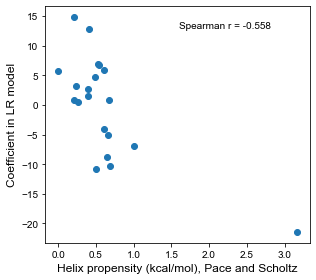

In [18]:
plt.figure(figsize=(4.5,4))
plt.scatter(h_propensity.values(), logreg.coef_.tolist())
plt.xlabel('Helix propensity (kcal/mol), Pace and Scholtz', fontsize=12)
plt.ylabel('Coefficient in LR model', fontsize=12)
corr = stats.spearmanr(list(h_propensity.values()), logreg.coef_[0].tolist())
plt.text(1.6, 13, "Spearman r = " + '{0:.3g}'.format(corr.correlation))
plt.tight_layout()
#plt.savefig('./fig.png', dpi=300)
plt.show()

## 3C: Uversky plot for all regions